# Subsetting GEDI L4A Footprints

This tutorial will demonstrate how to subset [Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD)](https://doi.org/10.3334/ORNLDAAC/2056) dataset to a study area of interest. GEDI L4A dataset is available for the period starting 2019-04-17 and covers latitudes of 52 North to 52 South. GEDI L4A data files are natively in HDF5 format, and each file represents one International Space Station (ISS) orbit. 

The [previous tutorial](1_gedi_l4a_search_download.ipynb) explains how to download GEDI L4A files for a study area of interest (bounding box or polygon) and a specific period. Once all the GEDI L4A files are downloaded from **IPFS**, the global orbits of GEDI L4A can be clipped or subsetted to the study area of interest.

This tutorial requires the following Python modules installed in your system: `ipfs_stac`, `requests`, `numpy`, `h5py`, `datetime`, `pandas`, `geopandas`, `contextily`, `shapely`. Requirements are also in [requirements.txt](requirements.txt). To install the necessary Python modules, you can copy the requirements.txt from this repository and run:
```bash
python -m venv .venv
pip install -r requirements.txt
```

In [1]:
%matplotlib inline
import requests
import h5py
import pandas as pd
import geopandas as gpd
import contextily as ctx
import h5py
import numpy as np
from glob import glob
from os import path
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import orient

# Additional imports
import json
import sys
from pathlib import Path
from ipfs_stac import client
# Import the easier_utils module containing helper functions
sys.path.append('scripts')
import easier_utils as eu

# Grabbing the root directory for this project
root_dir = Path.cwd()

## 1. Polygonal Area of Interest

We will use the boundary of the [Great Smokey Mountain National Park (GRSM)](https://www.nps.gov/grsm/planyourvisit/maps.htm) to demonstrate the spatial subsetting process. The boundary file is in ESRI Shapefile format in the folder called `grsm` in the repository. Let's read the boundary file and print out its coordinate system.

In [2]:
grsm_poly = gpd.read_file(
    Path(root_dir, "polygons", "grsm", "GRSM_BOUNDARY_POLYGON_fid17.shp")
)
grsm_poly.crs


<Projected CRS: EPSG:26917>
Name: NAD83 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 84°W and 78°W - onshore and offshore. Canada - Nunavut; Ontario; Quebec. United States (USA) - Florida; Georgia; Kentucky; Maryland; Michigan; New York; North Carolina; Ohio; Pennsylvania; South Carolina; Tennessee; Virginia; West Virginia.
- bounds: (-84.0, 23.81, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

As we see above, the boundary file is in the UTM 17N projection. Now let's plot our study area over a base map. First, we will convert to GRSM polygon into [Web Mercator (EPSG 3857)](https://epsg.io/3857) to bring it to the same coordinate reference system as the base map.

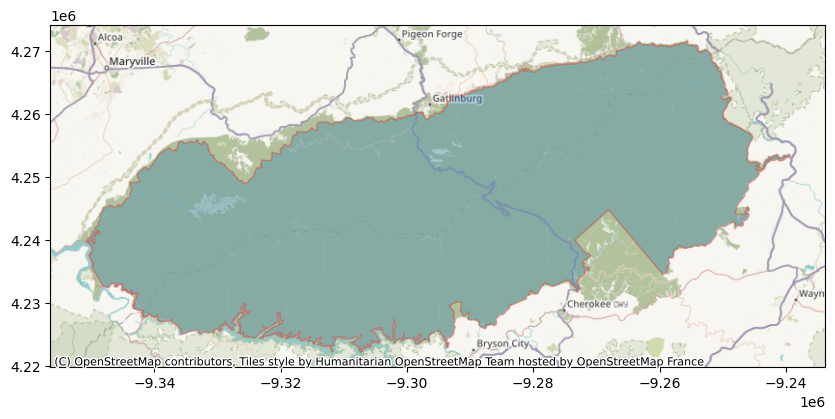

In [3]:
grsm_epsg3857 = grsm_poly.to_crs(epsg=3857)
ax = grsm_epsg3857.plot(figsize=(10, 5), alpha=0.3, edgecolor="red")

# Encapulate the plot in a try-except block to avoid errors when running the script.
# Raise an error if the plot fails but continue running the script and don't plot the map
try:
    ctx.add_basemap(ax)
except Exception as e:
    print(f"Error plotting the map: {e}")
    pass


## 2. Searching and Downloading GEDI L4A Files
We will search for all the GEDI L4A files with the orbits passing over the GRSM boundary using the NASA Earthdata Common Metadata Repository (CMR) API. Please refer to the [previous tutorial](1_gedi_l4a_search_download.ipynb) for more details.

In [4]:
# converting to WGS84 coordinate system
grsm_epsg4326 = grsm_poly.to_crs(epsg=4326)

# orienting coordinates clockwise
grsm_epsg4326.geometry = grsm_epsg4326.geometry.apply(orient, args=(1,))

# reducing number of vertices in the polygon
# CMR has 1000000 bytes limit
grsm_epsg4326 = grsm_epsg4326.simplify(0.0005)

doi = "10.3334/ORNLDAAC/2056"  # GEDI L4A DOI

# CMR API base url
cmrurl = "https://cmr.earthdata.nasa.gov/search/"

doisearch = cmrurl + "collections.json?doi=" + doi
concept_id = requests.get(doisearch).json()["feed"]["entry"][0]["id"]

geojson = {
    "shapefile": ("grsm.json", grsm_epsg4326.geometry.to_json(), "application/geo+json")
}

page_num = 1
page_size = 2000  # CMR page size limit

granule_arr = []

while True:

    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id,
        "page_size": page_size,
        "page_num": page_num,
        "simplify-shapefile": "true",  # this is needed to bypass 5000 coordinates limit of CMR
    }

    granulesearch = cmrurl + "granules.json"
    response = requests.post(granulesearch, data=cmr_param, files=geojson)
    granules = response.json()["feed"]["entry"]

    if granules:
        for g in granules:
            granule_url = ""
            granule_poly = ""

            # read file size
            granule_size = float(g["granule_size"])

            # reading bounding geometries
            if "polygons" in g:
                polygons = g["polygons"]
                multipolygons = []
                for poly in polygons:
                    i = iter(poly[0].split(" "))
                    ltln = list(map(" ".join, zip(i, i)))
                    multipolygons.append(
                        Polygon(
                            [
                                [float(p.split(" ")[1]), float(p.split(" ")[0])]
                                for p in ltln
                            ]
                        )
                    )
                granule_poly = MultiPolygon(multipolygons)

            # Get URL of HDF5 files
            for links in g["links"]:
                if (
                    "title" in links
                    and links["title"].startswith("Download")
                    and links["title"].endswith(".h5")
                ):
                    granule_url = links["href"]
            granule_arr.append([granule_url, granule_size, granule_poly])

        page_num += 1
    else:
        break

# adding bound as the last row into the dataframe
# we will use this later in the plot
granule_arr.append(["GRSM", 0, grsm_epsg4326.geometry.item()])

# creating a pandas dataframe
l4adf = pd.DataFrame(
    granule_arr, columns=["granule_url", "granule_size", "granule_poly"]
)

# Drop granules with empty geometry
l4adf = l4adf[l4adf["granule_poly"] != ""]

print("Total granules found: ", len(l4adf.index) - 1)
print("Total file size (MB): ", l4adf["granule_size"].sum())


Total granules found:  187
Total file size (MB):  58605.385666


There are 187 GEDI L4A files with total size of ~54 GB overlapping the GRSM area. Let's plot the bounding geometries of the first few files.

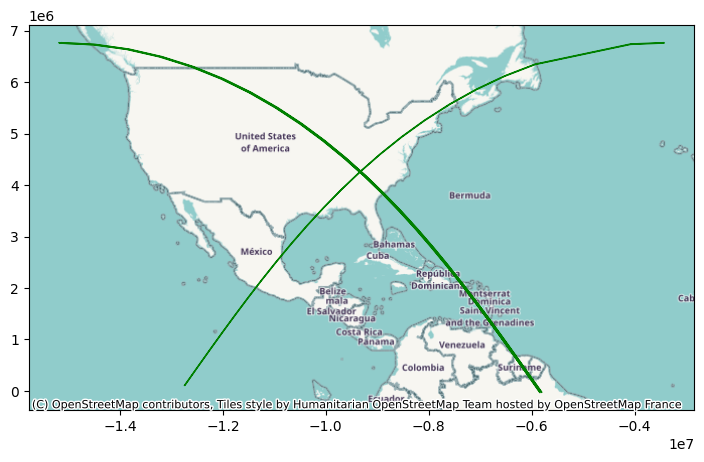

In [5]:
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
gdf.crs = "EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)
ax = gdf_epsg3857[:3].plot(figsize=(10, 5), edgecolor="green")
try:
    ctx.add_basemap(ax)
except Exception as e:
    print(f"Error plotting the map: {e}")
    pass


Each GEDI L4A file extends beyond the study area of interest. Now, let's plot a zoomed-in version of the above map over GRSM.

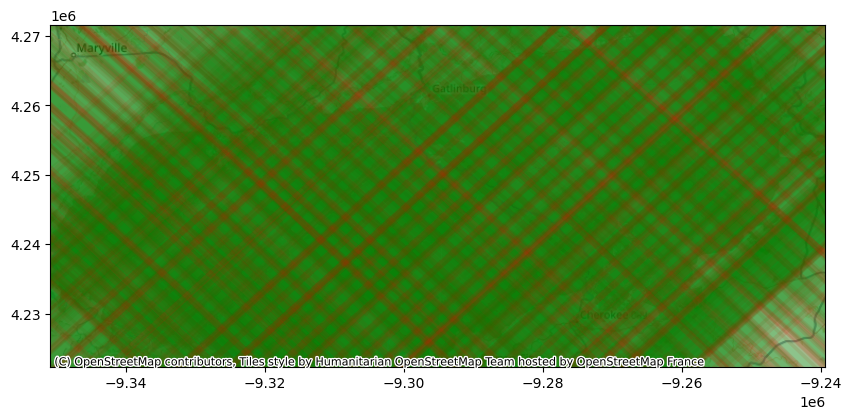

In [6]:
ax2 = gdf_epsg3857[:-1].plot(
    figsize=(10, 5), alpha=0.1, color="green", edgecolor="red", linewidth=5
)
minx, miny, maxx, maxy = grsm_epsg3857.total_bounds
ax2.set_xlim(minx, maxx)
ax2.set_ylim(miny, maxy)
try:
    ctx.add_basemap(ax2)
except Exception as e:
    print(f"Error plotting the map: {e}")
    pass


As we see in the figures above, GEDI has a good coverage over the GRSM area. 

## 3. Downloading the GEDI L4A files

Like the [previous tutorial](1_gedi_l4a_search_download.ipynb), we will download the files using the the `ipfs-stac` library and then save to our local file system. 

First, we'll create our Web3 object from `ipfs-stac` and query the Easier STAC API endpoint to grab the CIDs using the bounding box of the GRSM area.

In [7]:
# Setting the properties for to connect to the Easier STAC Endpoint our our local IPFS gateway
# If necessary, change the values below to match your local IPFS gateway.
ipfs_gateway_ip = "127.0.0.1"
ipfs_gateway_port = "8080"
stac_collection_endpoint = "https://stac.easierdata.info"

# Creating our client object with the properties set above
easier_client = client.Web3(
    stac_endpoint=stac_collection_endpoint,
    local_gateway=ipfs_gateway_ip,
    gateway_port=ipfs_gateway_port,
)

# Grab the bounding box of the GRSM National Park polygon
bbox_bounds = json.loads(geojson["shapefile"][1])["features"][0]["bbox"]

collection_name = "GEDI_L4A_AGB_Density_V2_1_2056.v2.1"
granule_results = easier_client.searchSTACByBox(
    bbox=bbox_bounds,
    collections=collection_name,
)

### 3a. Checking our query

For quality assurance, let's ensure the granules necessary for this tutorial were queried from the Easier STAC. We'll start by getting a list of the filenames for the CMR query and compare that against the STAC query.

In [8]:
# drop duplicate URLs if any
l4a_granules = l4adf[:-1].drop_duplicates(subset=["granule_url"])
# l4a_granules.to_csv("granules.txt", columns=["granule_url"], index=False, header=False)
l4a_granules_cmr_list = [
    url.split("/")[-1] for url in list(l4a_granules["granule_url"])
]

# Compare the number of granules found in the Easier STAC endpoint with the number of granules we need
stac_granule_ids = [item.id.split(".", 1)[-1] for item in granule_results]
eu.compare_search_results(l4a_granules_cmr_list, stac_granule_ids)


The STAC query has 29 extra granules.


If we have more than we need, we can filter the STAC search results.

In [9]:
# Create a dictionary of each granule file containing the pystac item object and CID
granule_payload = eu.get_cid_payload(granule_results)

# Creating a copy of the granule_payload dictionary as to modify the original dictionary
for granule_id, vals in granule_payload.copy().items():
    if vals["file_name"] not in l4a_granules_cmr_list:
        granule_payload.pop(granule_id)

stac_granule_ids = [vals["file_name"] for key, vals in granule_payload.items()]
eu.compare_search_results(l4a_granules_cmr_list, stac_granule_ids)


Excellent! All the requested items from the CMR appear in our STAC query.


### 3b. Saving the GEDI L4A files to a local directory
We'll next save the content down to the local directory `full_orbits`.


In [22]:
for k in granule_payload.keys():
    fetched_asset = easier_client.getAssetFromItem(
        granule_payload[k]["item"],
        granule_payload[k]["asset_key"],
        fetch_data=True,
    )
    # Set output path for the file
    print(f"Saving {granule_payload[k]['file_name']} to disk")
    output_dir = Path(root_dir, "full_orbits", granule_payload[k]["file_name"])
    # Save the content from IPFS to our local file system.
    easier_client.writeCID(fetched_asset.cid, output_dir)


✅  Fetching bafybeiddydzzb5z2smwos72qzci3wchhk4kk42i23jhfeldhkczsusq5ra - 332362 
Saving GEDI04_A_2019133103100_O02354_03_T00724_02_002_02_V002.h5 to disk


## 4. Subsetting the GEDI L4A files

Once all the GEDI L4A files are downloaded from IPFS, we can clip the full orbit files to retrieve the footprints within the area of interest, i.e., the GRSM boundary.

### 4a. Exploring the data structure
Let's first open one of the L4A file `GEDI04_A_2019133103100_O02354_03_T00724_02_002_02_V002.h5` we just downloaded and print the root-level variable group.

In [10]:
file_name = "GEDI04_A_2019133103100_O02354_03_T00724_02_002_02_V002.h5"
file_path = Path(root_dir, "full_orbits", file_name)

hf = h5py.File(file_path, "r")

hf.keys()


<KeysViewHDF5 ['ANCILLARY', 'BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011', 'METADATA']>

All science variables are organized by eight beams of the GEDI. Please refer to the [GEDI L4A user guide](https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density_V2_1.html) and [GEDI L4A data dictionary](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density_V2_1/comp/GEDI_L4A_V2_Product_Data_Dictionary.pdf) for details on file organization. Let's look into one of the beam group `BEAM0110` and print all the science dataset (SDS) variables within the group. 

In [11]:
beam0110 = hf.get("BEAM0110")
beam0110.keys()


<KeysViewHDF5 ['agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_prediction', 'agbd_se', 'agbd_t', 'agbd_t_se', 'algorithm_run_flag', 'beam', 'channel', 'degrade_flag', 'delta_time', 'elev_lowestmode', 'geolocation', 'l2_quality_flag', 'l4_quality_flag', 'land_cover_data', 'lat_lowestmode', 'lon_lowestmode', 'master_frac', 'master_int', 'predict_stratum', 'predictor_limit_flag', 'response_limit_flag', 'selected_algorithm', 'selected_mode', 'selected_mode_flag', 'sensitivity', 'shot_number', 'solar_elevation', 'surface_flag', 'xvar']>

In the above list of variables, 2 science dataset (SDS)  are particulary useful for spatial subsetting: `lat_lowestmode` and `lon_lowestmode`, which represent ground location of each GEDI shot.

Let's plot all the beams in the map. 

In [12]:
lat_l = []
lon_l = []
beam_n = []
for var in list(hf.keys()):
    if var.startswith("BEAM"):
        beam = hf.get(var)
        lat = beam.get("lat_lowestmode")[:]
        lon = beam.get("lon_lowestmode")[:]
        lat_l.extend(lat.tolist())  # latitude
        lon_l.extend(lon.tolist())  # longitude
        n = lat.shape[0]  # number of shots in the beam group
        beam_n.extend(np.repeat(str(var), n).tolist())
geo_arr = list(zip(beam_n, lat_l, lon_l))
l4adf = pd.DataFrame(geo_arr, columns=["beam", "lat_lowestmode", "lon_lowestmode"])
l4adf


,beam,lat_lowestmode,lon_lowestmode
0,BEAM0000,51.820311,-136.039649
1,BEAM0000,51.820308,-136.038820
2,BEAM0000,51.820305,-136.037992
3,BEAM0000,51.820302,-136.037163
4,BEAM0000,51.820299,-136.036335
...,...,...,...
1338244,BEAM1011,-0.243276,-52.168463
1338245,BEAM1011,-0.243705,-52.168161
1338246,BEAM1011,-0.244112,-52.167877
1338247,BEAM1011,-0.244559,-52.167559


The pandas dataframe `l4adf` contains beam names, latitude and longitude columns. This particular GEDI orbit recorded a total of 1,338,249 shots. Now we can convert `l4adf` to a geopandas dataframe `l4agdf` and clip the file by the boundary of the GRSM.

In [13]:
l4agdf = gpd.GeoDataFrame(
    l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode)
)
l4agdf.crs = "EPSG:4326"
l4agdf_gsrm = l4agdf[l4agdf["geometry"].within(grsm_epsg4326.geometry[0])]
l4agdf_gsrm


,beam,lat_lowestmode,lon_lowestmode,geometry
77915,BEAM0000,35.695545,-83.583207,POINT (-83.58321 35.69555)
77916,BEAM0000,35.695196,-83.582730,POINT (-83.58273 35.69520)
77917,BEAM0000,35.694867,-83.582310,POINT (-83.58231 35.69487)
77918,BEAM0000,35.694515,-83.581828,POINT (-83.58183 35.69452)
77919,BEAM0000,35.694179,-83.581389,POINT (-83.58139 35.69418)
...,...,...,...,...
1249364,BEAM1011,35.490195,-83.381600,POINT (-83.38160 35.49020)
1249365,BEAM1011,35.489855,-83.381146,POINT (-83.38115 35.48986)
1249366,BEAM1011,35.489514,-83.380690,POINT (-83.38069 35.48951)
1249367,BEAM1011,35.489177,-83.380240,POINT (-83.38024 35.48918)


The geopandas dataframe `l4agdf_gsrm` contains the shots (4,505 shots in total) that fall within the GSRM boundary. Now, let's plot these into a map.

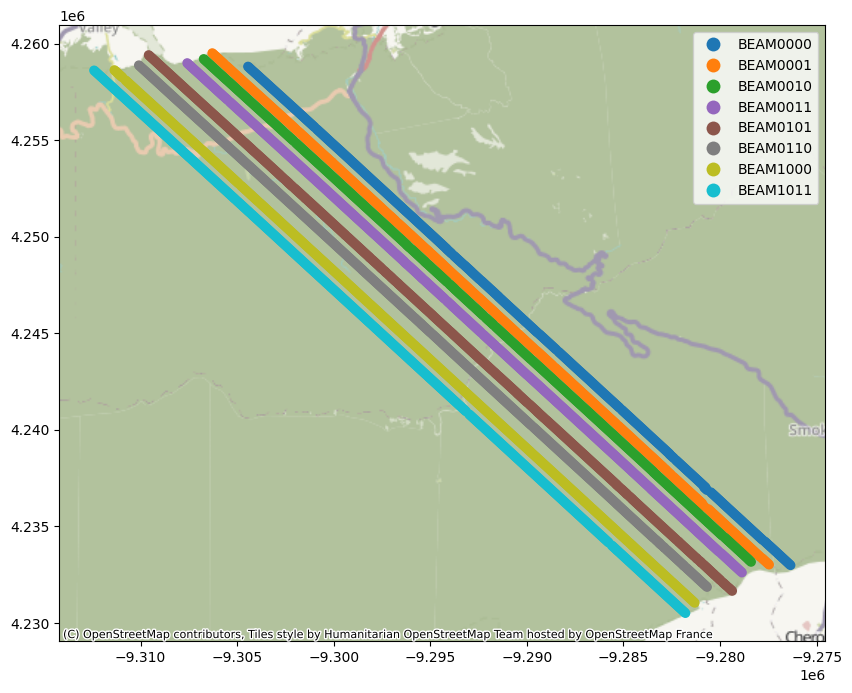

In [14]:
l4agdf_gsrm_epsg3857 = l4agdf_gsrm.to_crs(epsg=3857)
ax2 = l4agdf_gsrm_epsg3857.plot(column="beam", legend=True, figsize=(10, 8))
ctx.add_basemap(ax2)


The above map shows the swath coverage of GEDI - a typical swath is ~4200m wide. GEDI instrument produces eight ground tracks plotted in the map with different colors. Let's zoom in into an area and look at the locations of actual shots.

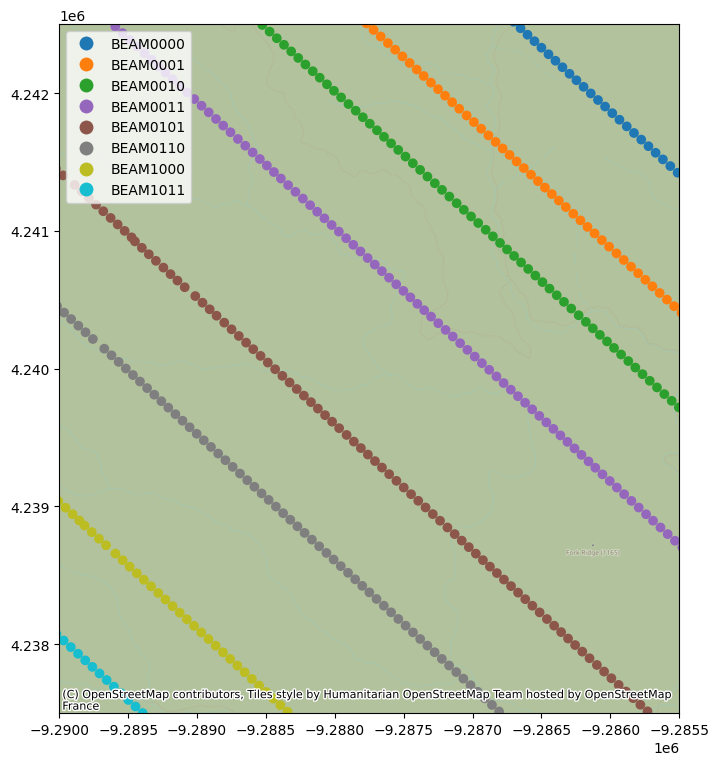

In [15]:
minx1, miny1, maxx1, maxy1 = [-9290000, 4237500, -9285500, 4242500]
ax3 = l4agdf_gsrm_epsg3857.plot(column="beam", legend=True, figsize=(8, 10))
ax3.set_xlim(minx1, maxx1)
ax3.set_ylim(miny1, maxy1)
ctx.add_basemap(ax3)

# close the opened hdf5 file
hf.close()


The GEDI shots (or footprints) are separated by ~60 m along the track and ~600 m across the track. For more detailed look on GEDI L4A data, refer to [this tutorial on exploring GEDI L4A](3_gedi_l4a_exploring_data.ipynb).

### 4b. Subsetting all downloaded files

In the Steps 2 and 3 above, we downloaded L4A files into the directory `full_orbits`. We will now loop over each of these files and create a clipped version of the files into a new directory `subsets`. 

In [ ]:
indir = Path(root_dir, "full_orbits")
outdir = Path(root_dir, "subsets")

# converting to WGS84 coordinate system
grsm_epsg4326 = grsm_poly.to_crs(epsg=4326)

for infile in glob(path.join(indir, "GEDI04_A*.h5")):
    name, ext = path.splitext(path.basename(infile))
    subfilename = "{name}_sub{ext}".format(name=name, ext=ext)
    outfile = path.join(outdir, path.basename(subfilename))
    hf_in = h5py.File(infile, "r")
    hf_out = h5py.File(outfile, "w")

    # copy ANCILLARY and METADATA groups
    var1 = ["/ANCILLARY", "/METADATA"]
    for v in var1:
        hf_in.copy(hf_in[v], hf_out)

    # loop through BEAMXXXX groups
    for v in list(hf_in.keys()):
        if v.startswith("BEAM"):
            beam = hf_in[v]
            # find the shots that overlays the area of interest (GRSM)
            lat = beam["lat_lowestmode"][:]
            lon = beam["lon_lowestmode"][:]
            i = np.arange(0, len(lat), 1)  # index
            geo_arr = list(zip(lat, lon, i))
            l4adf = pd.DataFrame(
                geo_arr, columns=["lat_lowestmode", "lon_lowestmode", "i"]
            )
            l4agdf = gpd.GeoDataFrame(
                l4adf,
                geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode),
            )
            l4agdf.crs = "EPSG:4326"
            l4agdf_gsrm = l4agdf[l4agdf["geometry"].within(grsm_epsg4326.geometry[0])]
            indices = l4agdf_gsrm.i

            # copy BEAMS to the output file
            for key, value in beam.items():
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        group_path = value2.parent.name
                        group_id = hf_out.require_group(group_path)
                        dataset_path = group_path + "/" + key2
                        hf_out.create_dataset(dataset_path, data=value2[:][indices])
                        for attr in value2.attrs.keys():
                            hf_out[dataset_path].attrs[attr] = value2.attrs[attr]
                else:
                    group_path = value.parent.name
                    group_id = hf_out.require_group(group_path)
                    dataset_path = group_path + "/" + key
                    hf_out.create_dataset(dataset_path, data=value[:][indices])
                    for attr in value.attrs.keys():
                        hf_out[dataset_path].attrs[attr] = value.attrs[attr]

    hf_in.close()
    hf_out.close()


Now, the subset files are created in the `subsets` directory. We will use the subset files to create a map of above ground biomass density (the variable `agbd` inside `BEAMXXXX` groups) of the GRSM. 

In [ ]:
lat_l = []
lon_l = []
agbd = []
for subfile in glob(path.join(outdir, "GEDI04_A*.h5")):
    hf_in = h5py.File(subfile, "r")
    for v in list(hf_in.keys()):
        if v.startswith("BEAM"):
            beam = hf_in[v]
            lat_l.extend(beam["lat_lowestmode"][:].tolist())
            lon_l.extend(beam["lon_lowestmode"][:].tolist())
            agbd.extend(beam["agbd"][:].tolist())
    hf_in.close()
geo_arr = list(zip(agbd, lat_l, lon_l))
df = pd.DataFrame(geo_arr, columns=["agbd", "lat_lowestmode", "lon_lowestmode"])
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon_lowestmode, df.lat_lowestmode)
)
gdf


In the above table, we see there are some shots with fill value (-9999). We will exclude these shots in the map below. The following is a map of aboveground biomass density (Mg/ha) or `agbd`.

In [ ]:
grsm_df = pd.DataFrame(
    [[-9999, 0, -9999, -9999, grsm_epsg4326.geometry.item()]],
    columns=["agbd", "l4_quality_flag", "lat_lowestmode", "lon_lowestmode", "geometry"],
)
gdf = pd.concat([gdf, grsm_df])
gdf.crs = "EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)
ax4 = gdf_epsg3857[-1:].plot(
    color="white", edgecolor="red", alpha=0.3, linewidth=5, figsize=(22, 7)
)
gdf_epsg3857[gdf_epsg3857["agbd"] != -9999][:-1].plot(
    ax=ax4, column="agbd", alpha=0.1, linewidth=0, legend=True
)
ctx.add_basemap(ax4)


### 4c. Saving the subsets to different formats
In the step above, we created a HDF5 formatted output, which is the native format of GEDI L4A datasets. The HDF5 files can be output to `geojson` or `csv` or `ESRI Shapefile` using the geopandas.

In [ ]:
subset_df = pd.DataFrame()
for subfile in glob(path.join(outdir, "GEDI04_A*_sub.h5")):
    hf_in = h5py.File(subfile, "r")
    for v in list(hf_in.keys()):
        if v.startswith("BEAM"):
            col_names = []
            col_val = []
            beam = hf_in[v]
            # copy BEAMS
            for key, value in beam.items():
                # looping through subgroups
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        if key2 != "shot_number":
                            # xvar variables have 2D
                            if key2.startswith("xvar"):
                                for r in range(4):
                                    col_names.append(key2 + "_" + str(r + 1))
                                    col_val.append(value2[:, r].tolist())
                            else:
                                col_names.append(key2)
                                col_val.append(value2[:].tolist())

                # looping through base group
                else:
                    # xvar variables have 2D
                    if key.startswith("xvar"):
                        for r in range(4):
                            col_names.append(key + "_" + str(r + 1))
                            col_val.append(value[:, r].tolist())
                    else:
                        col_names.append(key)
                        col_val.append(value[:].tolist())

            # create a pandas dataframe
            beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names)
            # Inserting BEAM names
            beam_df.insert(0, "BEAM", np.repeat(str(v), len(beam_df.index)).tolist())
            # Appending to the subset_df dataframe
            subset_df = pd.concat([subset_df, beam_df])

    hf_in.close()


Now, all the variables are stored in a pandas dataframe `subset_df`. We can print the dataframe.

In [ ]:
# Setting 'shot_number' as dataframe index. shot_number column is unique
subset_df = subset_df.set_index("shot_number")
subset_df.head()


The dataframe has 204 columns representing GEDI L4A variables. We can export it to a **CSV** file directly as:

In [ ]:
subset_df.to_csv(Path(outdir, "grsm_subset.csv"))  # Export to CSV


If we want to save the file as one of the geospatial formats (such as GEOJSON, KML, ESRI Shapefile), we need to first convert the dataframe into a geopandas dataframe, and export to various formats.

In [ ]:
subset_gdf = gpd.GeoDataFrame(
    subset_df,
    geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode),
)
subset_gdf.crs = "EPSG:4326"

# convert object types columns to strings. object types are not supported
for c in subset_gdf.columns:
    if subset_gdf[c].dtype == "object":
        subset_gdf[c] = subset_gdf[c].astype(str)

# Export to GeoJSON
subset_gdf.to_file(Path(outdir, "grsm_subset.geojson"), driver="GeoJSON")
# Export to ESRI Shapefile
subset_gdf.to_file(Path(outdir, "grsm_subset.shp"))
